In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn 
import random as rd 
import numpy as np
import plotly.express as px

In [3]:
# Tamanho do dataset
n = 1000
np.random.seed(42)

# Possíveis configurações
diametros = [8, 10, 12, 16, 20, 25, 32, 40, 50, 63]
max_curso = {8: 100, 10: 100, 12: 200, 16: 200, 20: 320, 25: 500, 32: 500, 40: 500, 50: 500, 63: 500}
tipos_amortecimento = ["P", "PPS", "PPV"]
protecao_especial = ["Nenhuma", "R3", "R8", "A6"]
posicoes = ["Horizontal", "Vertical", "Inclinada"]


In [4]:

# Função para gerar modelo fictício
def gerar_modelo(diam, curso, amort):
    return f"DSNU-{diam}-{curso}-{amort}-A"

In [5]:

# Geração básica dos dados
df = pd.DataFrame({
    "diametro_pistao_mm": np.random.choice(diametros, size=n),
    "tipo_amortecimento": np.random.choice(tipos_amortecimento, size=n),
    "protecao_especial": np.random.choice(protecao_especial, size=n, p=[0.6, 0.2, 0.1, 0.1]),
    "clamping_unit": np.random.choice([True, False], size=n, p=[0.2, 0.8]),
    "posicao_instalacao": np.random.choice(posicoes, size=n),
    "horas_operacao": np.random.randint(0, 2000, size=n),
    "manutencao_realizada": np.random.choice([True, False], size=n, p=[0.7, 0.3])
})

In [6]:

# Curso compatível com diâmetro
df["curso_mm"] = [np.random.randint(1, max_curso[d]+1) for d in df["diametro_pistao_mm"]]

# Modelo
df["modelo_cilindro"] = [gerar_modelo(d, c, a) for d, c, a in zip(df["diametro_pistao_mm"], df["curso_mm"], df["tipo_amortecimento"])]

# Condições de operação
df["temperatura_ambiente_C"] = np.round(np.random.uniform(-25, 125, size=n), 1)
df["pressao_operacao_bar"] = np.round(np.random.uniform(0, 12, size=n), 2)
df["velocidade_pistao_mm_s"] = np.round(np.random.uniform(5, 1200, size=n), 1)

# Sensores
df["pressao_entrada_sensor_bar"] = df["pressao_operacao_bar"] + np.round(np.random.uniform(0, 0.5, size=n), 2)
df["pressao_saida_sensor_bar"] = df["pressao_entrada_sensor_bar"] - np.round(np.random.uniform(0, 1.0, size=n), 2)
df["sensor_umidade_pct"] = np.round(np.random.uniform(0, 50, size=n), 1)
df["vibracao_mm_s"] = np.round(np.random.uniform(0, 15, size=n), 2)

# Variáveis calculadas
df["delta_pressao_bar"] = df["pressao_entrada_sensor_bar"] - df["pressao_saida_sensor_bar"]
df["vazamento_detectado"] = df["delta_pressao_bar"] > 0.5
df["umidade_interna_detectada"] = df["sensor_umidade_pct"] > 10
df["desgaste_detectado"] = df["vibracao_mm_s"] > 5

In [7]:

# ---------------------
# Regras de falha realistas
# ---------------------

def verificar_falha(row):
    # Limites de pressão e temperatura por proteção especial
    temp_min, temp_max = -20, 80
    press_min, press_max = 1, 10

    if row["protecao_especial"] == "A6":  # metal scraper
        press_min, press_max = 2, 10
    elif row["protecao_especial"] == "R3":  # alta corrosão
        temp_min, temp_max = -20, 80
    elif row["protecao_especial"] == "Nenhuma":
        temp_min, temp_max = -20, 80

    # Falhas por condição
    falha = False
    if not (press_min <= row["pressao_operacao_bar"] <= press_max):
        falha = True
    if not (temp_min <= row["temperatura_ambiente_C"] <= temp_max):
        falha = True
    if row["vazamento_detectado"]:
        falha = True
    if row["umidade_interna_detectada"]:
        falha = True
    if row["desgaste_detectado"]:
        falha = True
    if not row["manutencao_realizada"] and row["horas_operacao"] > 1500:
        falha = True

    return int(falha)

df["falha"] = df.apply(verificar_falha, axis=1)

In [10]:
# Exibir primeiras linhas
df.head()

,diametro_pistao_mm,tipo_amortecimento,protecao_especial,clamping_unit,posicao_instalacao,horas_operacao,manutencao_realizada,curso_mm,modelo_cilindro,temperatura_ambiente_C,...,velocidade_pistao_mm_s,pressao_entrada_sensor_bar,pressao_saida_sensor_bar,sensor_umidade_pct,vibracao_mm_s,delta_pressao_bar,vazamento_detectado,umidade_interna_detectada,desgaste_detectado,falha
0,32,P,Nenhuma,False,Inclinada,709,True,328,DSNU-32-328-P-A,58.5,...,950.1,4.29,3.36,29.8,11.64,0.93,True,True,True,1
1,16,PPV,Nenhuma,False,Horizontal,395,False,133,DSNU-16-133-PPV-A,108.8,...,964.6,5.48,5.16,48.5,9.76,0.32,False,True,True,1
2,40,PPV,R8,False,Vertical,911,False,42,DSNU-40-42-PPV-A,18.1,...,860.8,10.36,9.43,49.2,3.19,0.93,True,True,False,1
3,20,P,R8,False,Inclinada,1360,True,135,DSNU-20-135-P-A,24.2,...,249.1,11.59,10.80,29.0,5.62,0.79,True,True,True,1
4,32,P,R3,True,Inclinada,1004,True,42,DSNU-32-42-P-A,-7.7,...,300.4,7.65,6.73,0.1,0.12,0.92,True,False,False,1


In [9]:
# Salvar CSV
df.to_csv("datasheet_festo_dsnu.csv", index=False)
print("\nArquivo 'datasheet_festo_dsnu.csv' gerado com sucesso!")


Arquivo 'datasheet_festo_dsnu.csv' gerado com sucesso!


In [11]:
df.value_counts("falha")

falha
1    990
0     10
Name: count, dtype: int64

#Gerando eventos que não darão falha

In [12]:
# ---------- Parte 2: gerar 9000 linhas extras SAUDÁVEIS ----------
np.random.seed(123)
n_extra = 9000

df_extra = pd.DataFrame({
    "diametro_pistao_mm": np.random.choice(diametros, size=n_extra),
    "tipo_amortecimento": np.random.choice(tipos_amortecimento, size=n_extra),
    "protecao_especial": np.random.choice(protecao_especial, size=n_extra, p=[0.6, 0.2, 0.1, 0.1]),
    "clamping_unit": np.random.choice([True, False], size=n_extra, p=[0.2, 0.8]),
    "posicao_instalacao": np.random.choice(posicoes, size=n_extra),
    # horas de operação mantidas baixas para evitar falha por manutenção atrasada
    "horas_operacao": np.random.randint(0, 1200, size=n_extra),
    # garantir manutenção ok para a maioria
    "manutencao_realizada": np.ones(n_extra, dtype=bool)
})
df_extra["curso_mm"] = [np.random.randint(1, max_curso[d]+1) for d in df_extra["diametro_pistao_mm"]]
df_extra["modelo_cilindro"] = [gerar_modelo(d, c, a) for d, c, a in zip(df_extra["diametro_pistao_mm"], df_extra["curso_mm"], df_extra["tipo_amortecimento"])]

# Geração em faixas "seguras" (para evitar disparo das regras de falha)
# temperatura segura: -10 .. 60  (dentro do limite -20..80)
df_extra["temperatura_ambiente_C"] = np.round(np.random.uniform(-10, 60, size=n_extra), 1)

# pressão segura dependendo da proteção (A6 exige pressões um pouco maiores)
press_min_list = np.where(df_extra["protecao_especial"] == "A6", 2.0, 1.0)
pressao_vals = np.array([np.round(np.random.uniform(low, 9.5), 2) for low in press_min_list])
df_extra["pressao_operacao_bar"] = pressao_vals

df_extra["velocidade_pistao_mm_s"] = np.round(np.random.uniform(10, 800, size=n_extra), 1)

# Sensores com deltas controlados (delta <= 0.4 para evitar vazamento_detectado > 0.5)
df_extra["pressao_entrada_sensor_bar"] = df_extra["pressao_operacao_bar"] + np.round(np.random.uniform(0, 0.2, size=n_extra), 2)
deltas = np.random.uniform(0, 0.4, size=n_extra)  # <=0.4 -> não supera 0.5
df_extra["pressao_saida_sensor_bar"] = df_extra["pressao_entrada_sensor_bar"] - np.round(deltas, 3)

df_extra["sensor_umidade_pct"] = np.round(np.random.uniform(0, 5, size=n_extra), 2)  # baixo (<10)
df_extra["vibracao_mm_s"] = np.round(np.random.uniform(0, 4, size=n_extra), 2)  # baixo (<5)

df_extra["delta_pressao_bar"] = df_extra["pressao_entrada_sensor_bar"] - df_extra["pressao_saida_sensor_bar"]
df_extra["vazamento_detectado"] = df_extra["delta_pressao_bar"] > 0.5
df_extra["umidade_interna_detectada"] = df_extra["sensor_umidade_pct"] > 10
df_extra["desgaste_detectado"] = df_extra["vibracao_mm_s"] > 5

In [15]:
df_extra["falha"] = 0

In [16]:
df_extra.head()

,diametro_pistao_mm,tipo_amortecimento,protecao_especial,clamping_unit,posicao_instalacao,horas_operacao,manutencao_realizada,curso_mm,modelo_cilindro,temperatura_ambiente_C,...,velocidade_pistao_mm_s,pressao_entrada_sensor_bar,pressao_saida_sensor_bar,sensor_umidade_pct,vibracao_mm_s,delta_pressao_bar,vazamento_detectado,umidade_interna_detectada,desgaste_detectado,falha
0,12,PPS,Nenhuma,False,Inclinada,764,True,97,DSNU-12-97-PPS-A,10.9,...,340.0,3.70,3.648,1.03,3.36,0.052,False,False,False,0
1,12,PPV,Nenhuma,False,Inclinada,22,True,44,DSNU-12-44-PPV-A,44.8,...,761.4,6.77,6.410,4.00,1.51,0.360,False,False,False,0
2,32,PPV,Nenhuma,False,Inclinada,1195,True,376,DSNU-32-376-PPV-A,-2.9,...,139.2,4.63,4.625,3.91,0.28,0.005,False,False,False,0
3,10,PPV,Nenhuma,False,Inclinada,188,True,97,DSNU-10-97-PPV-A,56.3,...,529.4,4.26,3.996,0.20,3.20,0.264,False,False,False,0
4,16,PPV,R3,True,Vertical,189,True,173,DSNU-16-173-PPV-A,44.8,...,385.5,4.16,4.065,3.02,1.42,0.095,False,False,False,0


In [17]:
df_extra.value_counts("falha")

falha
0    9000
Name: count, dtype: int64

In [24]:
# ---------- Parte 3: concatenar e salvar ----------
df_total = pd.concat([df, df_extra], ignore_index=True)


In [25]:
print("\nContagem (após adicionar 9000 extras):")
print(df_total["falha"].value_counts())


Contagem (após adicionar 9000 extras):
falha
0    9010
1     990
Name: count, dtype: int64


In [20]:
# Salvar
df_total.to_csv("datasheet_festo_dsnu_plus_extra.csv", index=False)
print("\nCSV salvo como 'datasheet_festo_dsnu_plus_extra.csv' (no diretório atual).")


CSV salvo como 'datasheet_festo_dsnu_plus_extra.csv' (no diretório atual).


In [26]:
df_total.head()

,diametro_pistao_mm,tipo_amortecimento,protecao_especial,clamping_unit,posicao_instalacao,horas_operacao,manutencao_realizada,curso_mm,modelo_cilindro,temperatura_ambiente_C,...,velocidade_pistao_mm_s,pressao_entrada_sensor_bar,pressao_saida_sensor_bar,sensor_umidade_pct,vibracao_mm_s,delta_pressao_bar,vazamento_detectado,umidade_interna_detectada,desgaste_detectado,falha
0,32,P,Nenhuma,False,Inclinada,709,True,328,DSNU-32-328-P-A,58.5,...,950.1,4.29,3.36,29.8,11.64,0.93,True,True,True,1
1,16,PPV,Nenhuma,False,Horizontal,395,False,133,DSNU-16-133-PPV-A,108.8,...,964.6,5.48,5.16,48.5,9.76,0.32,False,True,True,1
2,40,PPV,R8,False,Vertical,911,False,42,DSNU-40-42-PPV-A,18.1,...,860.8,10.36,9.43,49.2,3.19,0.93,True,True,False,1
3,20,P,R8,False,Inclinada,1360,True,135,DSNU-20-135-P-A,24.2,...,249.1,11.59,10.80,29.0,5.62,0.79,True,True,True,1
4,32,P,R3,True,Inclinada,1004,True,42,DSNU-32-42-P-A,-7.7,...,300.4,7.65,6.73,0.1,0.12,0.92,True,False,False,1


In [27]:
df_total.nunique()


diametro_pistao_mm              10
tipo_amortecimento               3
protecao_especial                4
clamping_unit                    2
posicao_instalacao               3
horas_operacao                1535
manutencao_realizada             2
curso_mm                       500
modelo_cilindro               5732
temperatura_ambiente_C        1093
pressao_operacao_bar          1053
velocidade_pistao_mm_s        5936
pressao_entrada_sensor_bar    1774
pressao_saida_sensor_bar      7578
sensor_umidade_pct             887
vibracao_mm_s                  939
delta_pressao_bar             1219
vazamento_detectado              2
umidade_interna_detectada        2
desgaste_detectado               2
falha                            2
dtype: int64

In [28]:
# Salva a coluna modelo_cilindro separada
modelo_cilindro = df_total["modelo_cilindro"]

In [33]:
# Aplica get_dummies nas demais colunas
df_total_encoded = pd.get_dummies(
    df_total.drop(columns=["modelo_cilindro"]),
    drop_first=True
)

In [31]:
# Recoloca a coluna modelo_cilindro no final
df_total_encoded["modelo_cilindro"] = modelo_cilindro

In [34]:
df_total_encoded.head()

,diametro_pistao_mm,clamping_unit,horas_operacao,manutencao_realizada,curso_mm,temperatura_ambiente_C,pressao_operacao_bar,velocidade_pistao_mm_s,pressao_entrada_sensor_bar,pressao_saida_sensor_bar,...,umidade_interna_detectada,desgaste_detectado,falha,tipo_amortecimento_PPS,tipo_amortecimento_PPV,protecao_especial_Nenhuma,protecao_especial_R3,protecao_especial_R8,posicao_instalacao_Inclinada,posicao_instalacao_Vertical
0,32,False,709,True,328,58.5,3.87,950.1,4.29,3.36,...,True,True,1,False,False,True,False,False,True,False
1,16,False,395,False,133,108.8,5.28,964.6,5.48,5.16,...,True,True,1,False,True,True,False,False,False,False
2,40,False,911,False,42,18.1,10.00,860.8,10.36,9.43,...,True,False,1,False,True,False,False,True,False,True
3,20,False,1360,True,135,24.2,11.15,249.1,11.59,10.80,...,True,True,1,False,False,False,False,True,True,False
4,32,True,1004,True,42,-7.7,7.54,300.4,7.65,6.73,...,False,False,1,False,False,False,True,False,True,False


In [36]:
X = df_total_encoded.drop(columns = "falha")
y = df_total_encoded["falha"]

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=432, stratify= y)

In [ ]:
# Concatenar treino e teste se quiser padronizar todos
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Alinhar colunas (caso o one-hot tenha gerado colunas diferentes)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [39]:
import xgboost as xgb
modelo = xgb.XGBClassifier(objective='binary:logistic')  # Corrige 'object' → 'objective'
modelo.fit(X_train, y_train)
preds = modelo.predict(X_test)


In [40]:
from sklearn.metrics import accuracy_score
acuracia = accuracy_score(y_test, preds)
print(f'A acurácia do modelo é {acuracia:.2%}')

A acurácia do modelo é 99.65%


In [41]:
import joblib 
joblib.dump(modelo, 'modelo_DSNU_xgboost.pkl')

['modelo_DSNU_xgboost.pkl']

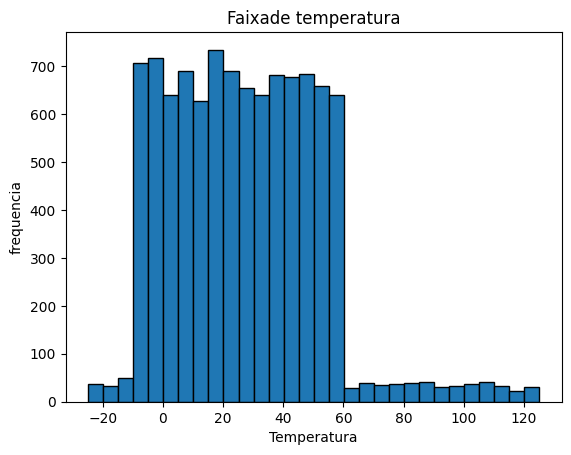

In [42]:
plt.hist(df_total_encoded["temperatura_ambiente_C"], bins=30, edgecolor = "black")
plt.title("Faixade temperatura")
plt.xlabel("Temperatura")
plt.ylabel("frequencia")
plt.show()

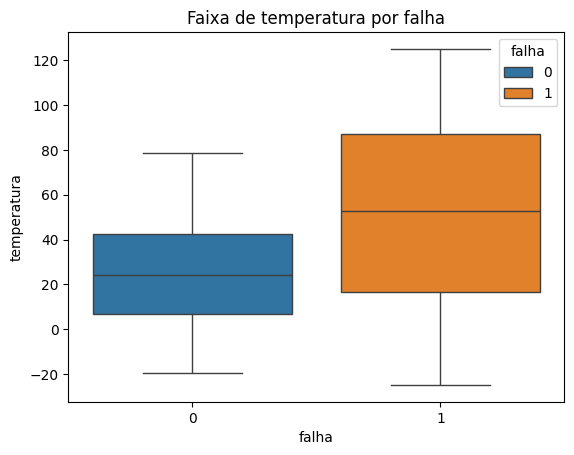

In [45]:
sns.boxplot(data= df_total_encoded, y = "temperatura_ambiente_C",x ="falha", hue ="falha")
plt.title("Faixa de temperatura por falha")
plt.xlabel("falha")
plt.ylabel("temperatura")
plt.show()

In [46]:
px.histogram(df_total_encoded, x="temperatura_ambiente_C", title = "Distribuição de temperatura")

In [48]:
# Carregar o modelo
modelo_carregado = joblib.load('modelo_DSNU_xgboost.pkl')

# Fazer previsões novamente com os dados de teste
predicoes = modelo_carregado.predict(X_test)

# Ver resultado
print(predicoes[:10])


[0 0 0 0 1 0 0 0 0 0]


In [50]:
X_test.head(10)

,diametro_pistao_mm,clamping_unit,horas_operacao,manutencao_realizada,curso_mm,temperatura_ambiente_C,pressao_operacao_bar,velocidade_pistao_mm_s,pressao_entrada_sensor_bar,pressao_saida_sensor_bar,...,vazamento_detectado,umidade_interna_detectada,desgaste_detectado,tipo_amortecimento_PPS,tipo_amortecimento_PPV,protecao_especial_Nenhuma,protecao_especial_R3,protecao_especial_R8,posicao_instalacao_Inclinada,posicao_instalacao_Vertical
7784,63,True,871,True,165,54.5,4.50,170.9,4.69,4.558,...,False,False,False,True,False,True,False,False,False,False
2056,20,False,579,True,240,31.3,5.90,590.7,5.96,5.767,...,False,False,False,False,False,True,False,False,True,False
6042,32,False,172,True,67,6.2,9.49,573.5,9.49,9.462,...,False,False,False,True,False,True,False,False,True,False
1137,10,False,329,True,52,44.4,6.92,228.1,6.92,6.770,...,False,False,False,False,False,True,False,False,False,True
923,50,True,466,True,395,96.2,2.88,925.9,3.12,2.780,...,False,True,True,False,False,False,False,True,False,False
8997,40,False,516,True,317,12.4,1.23,129.7,1.25,1.138,...,False,False,False,False,True,True,False,False,False,True
9530,50,False,500,True,309,19.3,4.76,630.4,4.78,4.519,...,False,False,False,False,False,True,False,False,False,False
9647,50,True,903,True,478,30.2,1.54,466.3,1.57,1.327,...,False,False,False,False,True,False,True,False,True,False
4589,32,False,399,True,121,35.6,5.03,165.7,5.12,4.726,...,False,False,False,False,False,True,False,False,False,False
4883,25,False,1032,True,217,29.1,7.97,341.1,8.07,7.691,...,False,False,False,True,False,True,False,False,False,True
